# Szeregi Czasowe (przykład HRV)

Dane pochodzą z https://physionet.org/physiobank/database/fantasia/
Informacje dotyczące zmiennośći rytmu zatokowego: https://en.wikipedia.org/wiki/Heart_rate_variability

In [2]:
import os 
import numpy as np

rr_data = []
for fn in sorted(os.listdir('./data/rr')):
    rr = open('./data/rr/' + fn).readlines()
    rr = [float(rr_i.strip()) for rr_i in rr]
    rr = np.array(rr)
    rr_data.append(rr)
    
print  sorted(os.listdir('./data/rr'))    

['O1.txt', 'O2.txt', 'O3.txt', 'O4.txt', 'O5.txt', 'Y1.txt', 'Y2.txt', 'Y3.txt', 'Y4.txt', 'Y5.txt']


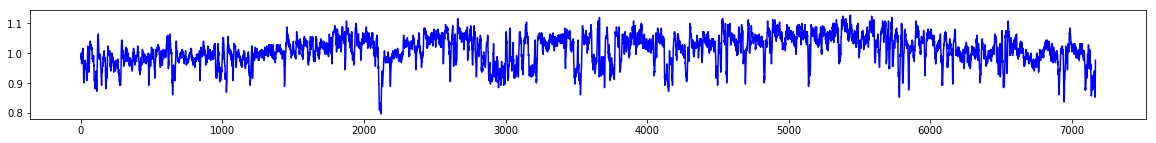

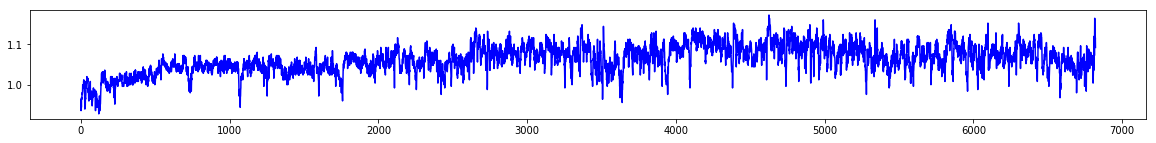

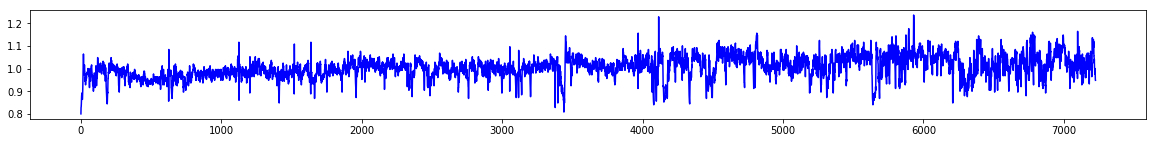

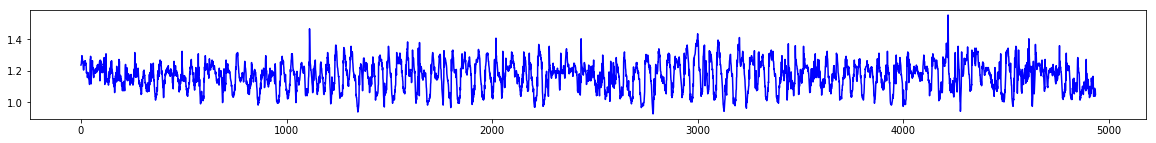

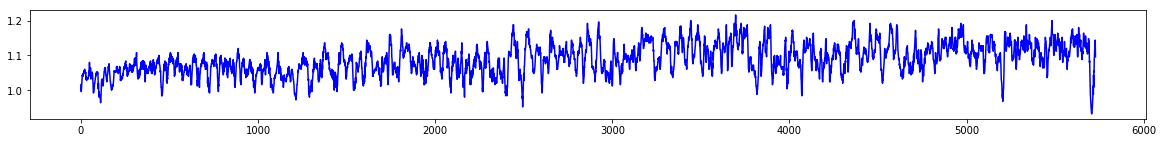

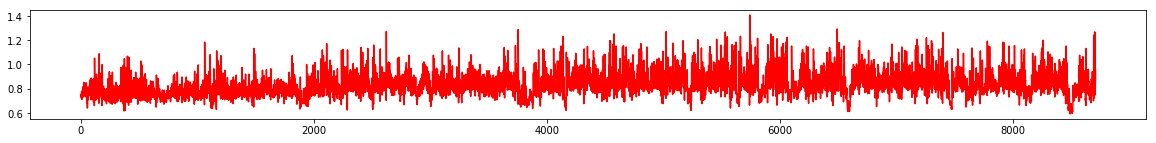

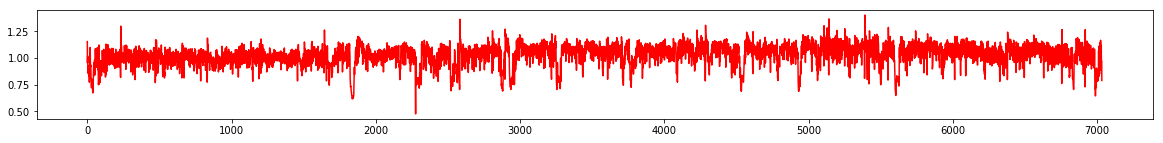

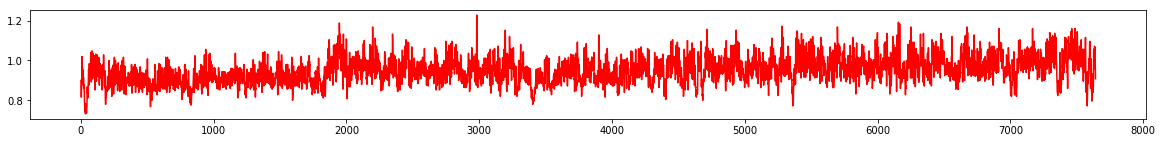

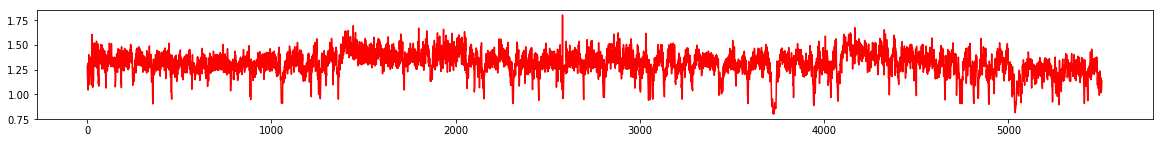

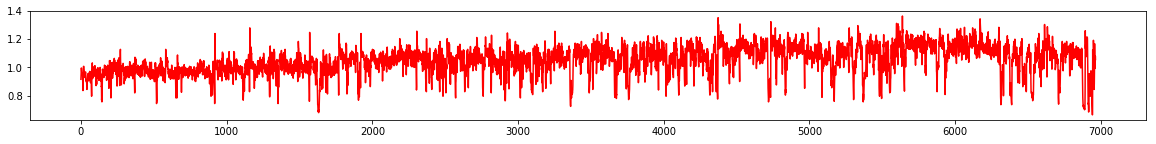

In [3]:
import matplotlib.pyplot as plt

for i in range(10):
    plt.figure(figsize=(20,2))
    plt.plot(rr_data[i], c ='b' if i<5 else 'r')

plt.show()

In [4]:
def adnn(rr):
    return np.mean(rr)

def sdnn(rr):
    d_rr = rr[1:] - rr[:-1]
    return d_rr.std()

def rmssd(rr):
    d_rr = rr[1:] - rr[:-1]
    return np.sqrt((d_rr**2).mean())

def nn50(rr):
    dd_r = rr[1:] - rr[:-1]
    return np.sum(dd_r < 0.05)

def pnn50(rr):
    dd_r = np.abs(rr[1:] - rr[:-1])
    return float(np.sum(dd_r < 0.05)) / len(dd_r)

def nn20(rr):
    dd_r = np.abs(rr[1:] - rr[:-1])
    return np.sum(dd_r < 0.05)

def pnn20(rr):
    dd_r = rr[1:] - rr[:-1]
    return float(np.sum(dd_r < 0.02)) / len(dd_r)

metrics = [adnn, sdnn, rmssd, nn50, pnn50, nn20, pnn20]



In [11]:
import pandas as pd


data = []
for subject_i in range(10):
    rr = rr_data[subject_i]
    row = {'age' : 'old' if subject_i<5 else 'young'}
    for metric in metrics:
        # use name of the function as column name
        row[metric.__name__] = metric(rr)
    data.append(row)

df_hrv = pd.DataFrame(data)
df_hrv

,adnn,age,nn20,nn50,pnn20,pnn50,rmssd,sdnn
0,1.011468,old,7125,7164,0.897028,0.994140,0.015541,0.015541
1,1.061764,old,6783,6808,0.895323,0.994429,0.015358,0.015358
2,1.003598,old,6991,7091,0.822723,0.967479,0.024428,0.024428
3,1.165764,old,4321,4612,0.774873,0.875583,0.038269,0.038269
4,1.087857,old,5722,5725,0.950768,0.998953,0.011445,0.011445
5,0.829640,young,4612,6847,0.621339,0.529689,0.091829,0.091829
6,1.028231,young,3854,5485,0.628039,0.547988,0.074860,0.074860
7,0.951675,young,6591,7080,0.726606,0.862583,0.034481,0.034481
8,1.312796,young,1820,3697,0.574437,0.330428,0.107332,0.107332
9,1.047010,young,5021,6058,0.658050,0.721097,0.053479,0.053479


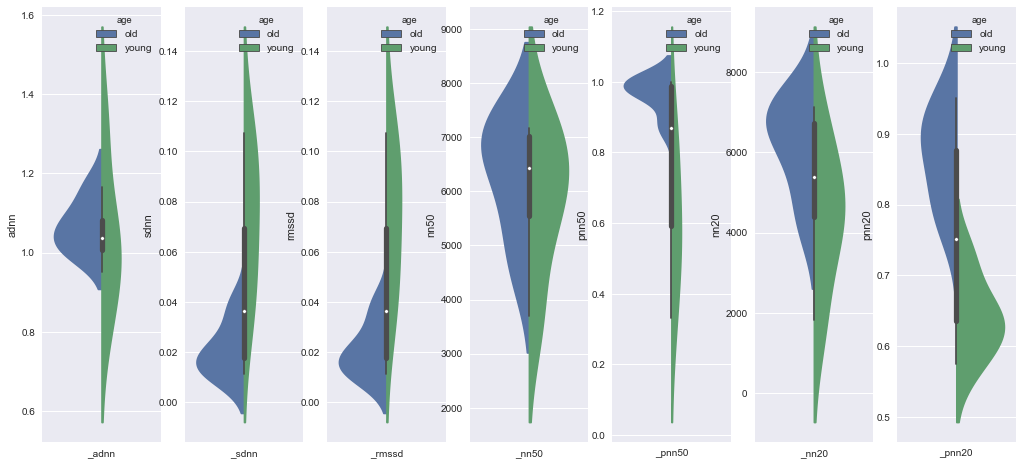

In [6]:
import seaborn as sn

fig = plt.figure(figsize=(20, 8))
for plot_i, m in enumerate(metrics):
    fig.add_subplot(1, len(metrics)+1, plot_i + 1)
    sn.violinplot(data=df_hrv, y=m.__name__, x=['_'+m.__name__]*10,  hue ='age', split=True)
    
plt.show()

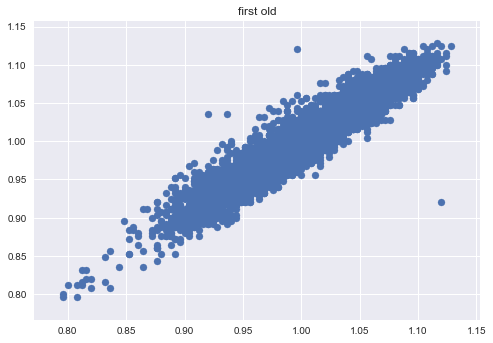

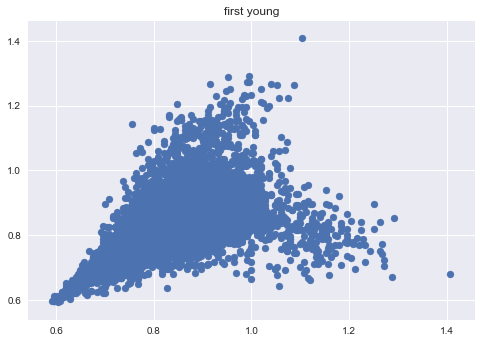

In [7]:
#poincare plot
rr = rr_data[0]
plt.figure()
P = np.vstack([rr[1:], rr[:-1]]).T
plt.scatter(P[:,0], P[:,1])
plt.title('first old')
rr = rr_data[5]
plt.figure()
P = np.vstack([rr[1:], rr[:-1]]).T
plt.scatter(P[:,0], P[:,1])
plt.title('first young')
plt.show()

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 4
         Function evaluations: 56
         Gradient evaluations: 7


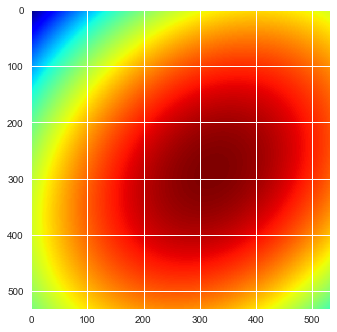

In [8]:
### do przepisania 

from scipy import optimize
#ellipsis fitting by quadratic equation fitting

rr = rr_data[0]
P = np.vstack([rr[1:], rr[:-1]]).T

def cost(u):
    A,B,C,D,E,F = u
    x, y = P.T
    err = A*x**2 + B*x*y + C*y**2 +D*x + E*y + F
    return np.mean(err ** 2)

(A,B,C,D,E,F) = optimize.fmin_bfgs(cost, x0 = np.array([1.,1.,1.,1.,1.,1.]))

x_min, x_max = P[:, 1].min() - 0.1, P[:, 1].max() + 0.1
y_min, y_max = P[:, 0].min() - 0.1, P[:, 0].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.001),
                     np.arange(y_min, y_max, 0.001))

N = xx.shape
xx, yy = xx.ravel(), yy.ravel()
z = A*xx**2 + B*xx*yy + C*yy**2 +D*xx + E*yy + F
z = z / z.max()
plt.imshow(z.reshape(N), cmap='jet')
plt.show()

#TODO trzeba dodac tutaj plot elipsy a nie plot powierzchni

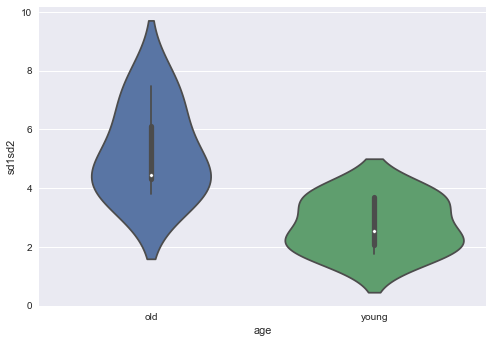

In [43]:
#oczywiscie mozemy tez zauwazyc iz SD1 oraz SD2 moze zostac obliczone w nieco prostszy sposob

def poincare_sd1sd2(rr):
    diff_rr = np.diff(rr)
    sd1 = np.sqrt(np.std(diff_rr, ddof=1) ** 2 * 0.5)
    sd2 = np.sqrt(2 * np.std(rr, ddof=1) ** 2 - 0.5 * np.std(diff_rr,
                                                              ddof=1) ** 2)
    return sd1, sd2

sd1sd2 = []
for sd1, sd2 in map(poincare_sd1sd2, rr_data):
    sd1sd2.append( sd2/sd1) 
    
df_hrv = df_hrv.assign(sd1sd2 = sd1sd2)
    
sn.violinplot(y='sd1sd2', x='age', data=df_hrv)
plt.show()


In [46]:
#przyjrzyjmy sie teraz miarom 

#ta implementacja pochodzi z https://github.com/rhenanbartels/hrv/blob/develop/hrv/classical.py

from scipy.signal import welch

def frequency_domain(rri, fs=4.0, interp_method=None, 
                     vlf_band=(0, 0.04), lf_band=(0.04, 0.15), hf_band=(0.15, 0.4)):
    
    if interp_method is not None:
        time_interp, rri = _interpolate_rri(rri, fs, interp_method)

    fxx, pxx = welch(x=rri, fs=fs)
    
    return _auc(fxx, pxx, vlf_band, lf_band, hf_band)


def _auc(fxx, pxx, vlf_band, lf_band, hf_band):
    vlf_indexes = np.logical_and(fxx >= vlf_band[0], fxx < vlf_band[1])
    lf_indexes = np.logical_and(fxx >= lf_band[0], fxx < lf_band[1])
    hf_indexes = np.logical_and(fxx >= hf_band[0], fxx < hf_band[1])

    vlf = np.trapz(y=pxx[vlf_indexes], x=fxx[vlf_indexes])
    lf = np.trapz(y=pxx[lf_indexes], x=fxx[lf_indexes])
    hf = np.trapz(y=pxx[hf_indexes], x=fxx[hf_indexes])
    total_power = vlf + lf + hf
    lf_hf = lf / hf
    lfnu = (lf / (total_power - vlf)) * 100
    hfnu = (hf / (total_power - vlf)) * 100

    return dict(zip(['total_power', 'vlf', 'lf', 'hf', 'lf_hf', 'lfnu',
                    'hfnu'], [total_power, vlf, lf, hf, lf_hf, lfnu, hfnu]))

map(frequency_domain, rr_data)

[{'hf': 0.0002958669476846859,
  'hfnu': 32.02697713085247,
  'lf': 0.0006279384632220746,
  'lf_hf': 2.1223677336587357,
  'lfnu': 67.97302286914753,
  'total_power': 0.001211467085217736,
  'vlf': 0.0002876616743109755},
 {'hf': 0.00010933072483369254,
  'hfnu': 37.03719239724973,
  'lf': 0.00018586099396897536,
  'lf_hf': 1.6999886742880024,
  'lfnu': 62.96280760275026,
  'total_power': 0.00038011751106707854,
  'vlf': 8.492579226441063e-05},
 {'hf': 0.0004213509685995516,
  'hfnu': 47.70761187939269,
  'lf': 0.0004618434567779932,
  'lf_hf': 1.0961015666180307,
  'lfnu': 52.2923881206073,
  'total_power': 0.0012401416196159698,
  'vlf': 0.00035694719423842486},
 {'hf': 0.0008534678892255678,
  'hfnu': 14.700628067932447,
  'lf': 0.004952188068340624,
  'lf_hf': 5.802430449766789,
  'lfnu': 85.29937193206756,
  'total_power': 0.0061674613311037095,
  'vlf': 0.0003618053735375186},
 {'hf': 0.00017507381303792728,
  'hfnu': 24.333118246429372,
  'lf': 0.0005444139700932688,
  'lf_hf':

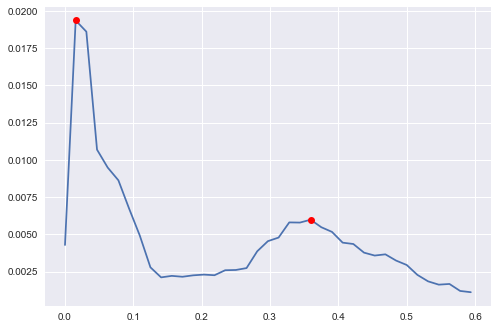

In [90]:
#poszukajmy lokalnych maksimow dla poszczegolnych zakresow czestotliwosci

from scipy.signal import argrelmax

rr= rr_data[7] 
fxx, pxx = welch(x=rr, fs=4.0)
x, y = fxx[fxx<0.6], pxx[fxx<0.6]

extrema = argrelmax(y, order=4)

plt.plot(x, y)
plt.plot(x[extrema],y[extrema] , 'ro')

plt.show()

